<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/chi2blockworsening_fromhdf5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def chi2z_arr(arr, blocksize):
  block_zs = np.sum(arr[0:(len(arr)-(len(arr)%blocksize))].reshape(-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdf_block_chi2 = scipy.stats.chi2.cdf(x=np.sum(np.square(block_zs)), df=len(block_zs))
  return cdf_block_chi2

def chi2z_arrs(arrs, blocksize):
  block_zs = np.sum(arrs[:,0:(len(arrs)-(len(arrs)%blocksize))].reshape(
      len(arrs),-1,blocksize), axis=-1)/np.sqrt(blocksize)
  cdfs_block_chi2 = scipy.stats.chi2.cdf(
      x=np.sum(np.square(block_zs), axis=-1), df=block_zs.shape[-1])
  return cdfs_block_chi2

def perform_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  blocksizes = [2]#],3,6,10,15,20]

  for blocksize in blocksizes:
    cdf_block_chi2 = chi2z_arr(values, blocksize)
    cdfs_block_chi2 = chi2z_arrs(rng_permutations, blocksize)

    permutepval_block_chi2 = np.mean(cdfs_block_chi2 >= cdf_block_chi2)
    toreturndict['pval_permute_blocksize'+str(blocksize)] = permutepval_block_chi2
    toreturndict['chi2cdf_permute_blocksize'+str(blocksize)] = cdf_block_chi2

  return toreturndict

In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/GCP_data/all_data
#data at https://drive.google.com/drive/u/0/folders/1MUS-xbwoBiodWLz4gese19ti_ftlKsVu

/content/drive/MyDrive/GCP_data/all_data


In [5]:
#install utilities code for reading/parsing data at https://github.com/AvantiShri/gcpdatautils
!pip uninstall -y gcpdatautils #uninstall the pre-existing version if want to fetch latest
!pip install git+https://github.com/AvantiShri/gcpdatautils.git@main #install latest from github

#Note: the code that was used to consolidate the downloaded csv.gz files into hdf5 files
# is at https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/Consolidate_GCP_as_HDF5.ipynb

Found existing installation: gcpdatautils 0.1.1.3
Uninstalling gcpdatautils-0.1.1.3:
  Successfully uninstalled gcpdatautils-0.1.1.3
  Cloning https://github.com/AvantiShri/gcpdatautils.git (to revision main) to /tmp/pip-req-build-qhaqr3qj
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-qhaqr3qj
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 55a9bc16c7c36ea920eafb44079d401f76da48f1
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.1.3-py3-none-any.whl size=6405 sha256=4e7c836124a8834c74096ee17ab08f1b178407121f0e1c84a365e35244413b4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-d1cala4p/wheels/8c/35/d9/946037b24577e21d0dce0d66645d002768f5bac3497186d55f
Successfully built gcpdatautils


Load the timeperiods

In [6]:
from datetime import datetime
from bs4 import BeautifulSoup

def parse_events_html(event_file, exclude_events_longer_than_days=7):
    soup = BeautifulSoup(open(event_file).read(), features="lxml")
    #the 'recipe' and 'statistic' columns don't always get parsed correctly due
    # to the break, but we can work around it
    rows = [[td.contents[0].rstrip() for td in row.find_all("td") ]
            for row in soup.body.table.tbody.find_all("tr")]
    #prepare the event IDs to be analyzed
    included_events = []
    for row in rows:
        if row[-1].startswith("Yes"): #only keep those events used in the GCP analysis (e.g. exclude events noted as redundant or post-hoc)
            event_num = row[0]
            event_name = row[1]
            start, end = row[2], row[3]
            resolution = row[4]
            start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
            end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
            duration = 1 + (end_datetime - start_datetime).total_seconds()
            if (end_datetime <= start_datetime):
                print("Skipping because end < start:", event_num, event_name, start, end)
                continue
            if (duration > exclude_events_longer_than_days*24*60*60):
                print("Skipping because event is more than",exclude_events_longer_than_days,
                      "days long!", event_num, event_name, start, end)
                continue
            if ("New Year Var" in event_name or "New Year Dev-Net Var" in event_name):
                print("Skipping because redundant with a corresponding 'mean' event: ",
                      event_num, event_name, start, end)
                continue
        else:
            continue
        included_events.append((event_num, event_name, start_datetime, end_datetime, duration, resolution))

    return included_events

In [7]:
#download the formal event registry if not already present
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

# we will parse the events file, dropping events longer than 30 days for memory efficiency
# we will also drop 'New Year Var...' events as they tend to be redundant in duration
# with the 'mean' events, and we are going to do a standard analysis on all the events
included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html",
                                    exclude_events_longer_than_days=2)

--2024-06-15 09:46:22--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [ <=>                ] 184.64K  --.-KB/s    in 0.06s   

2024-06-15 09:46:23 (2.87 MB/s) - ‘pred_formal.html’ saved [189067]

Skipping because event is more than 2 days long! 25 Pray for Peace 1999-04-03 20:00:00 1999-05-03 19:01:59
Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because event is more than 2 days long! 46 Papal Visit, Israel 2000-03-21 00:00:00 2000-03-26 23:59:59
Skipping because event is more than 2 days long! 51 Kursk, 10 days 2000-08-12 07:28:00 2000-08-21 14:29:59
Skipping because event is more than 2 days long! 53 Peace Summit Relig Spirit

In [8]:
import numpy as np
from collections import defaultdict
import h5py
from datetime import datetime, timedelta
from gcpdatautils import GCPHdf5DataReader, GCPMissingDataError

#Refer to the github repo https://github.com/AvantiShri/gcpdatautils for the
# code for reading from the hdf5 files
#Instantiate the hdf5 data reader
#it will auto-load a rotteneggs.txt file specifying bad data time periods (downloaded from https://global-mind.org/rotteneggs and saved in the package)
# this rotten egg file can be overridden by altering the arguments to the GCPHdf5DataReader
gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


Load the empirical variances

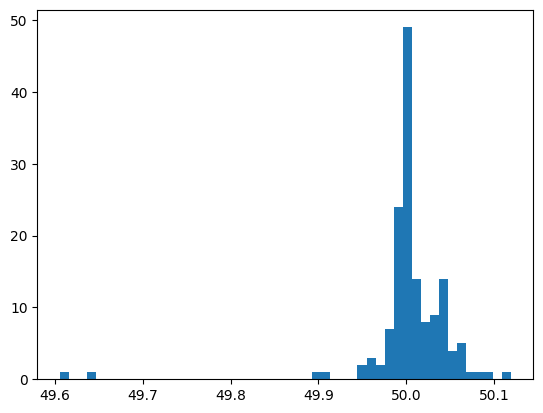

In [9]:
import json
from matplotlib import pyplot as plt

device_to_empirical_variances = json.loads(open("empirical_device_variances.json").read())
plt.hist(device_to_empirical_variances.values(), bins=50)
plt.show()

Load the data

In [10]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy
import os


def normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances):
  data = np.array(data) #make a copy, just in case
  for i,device in enumerate(devices):
    scalefactor = (np.sqrt(device_to_empirical_variances[str(int(device))])/np.sqrt(50))
    data[:,i] = ((data[:,i]-100)/scalefactor)+100
  return data


def compute_composite_z(egg_values):

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  egg_zscores = (egg_values - 100)/np.sqrt(50)
  composite_z_scores = np.nansum(egg_zscores, axis=1)/np.sqrt(num_nonnan_eggs)

  return composite_z_scores


def get_normalized_data(start_datetime, end_datetime, device_to_empirical_variances):
  data, devices = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=DAY_NORMALIZE)
  if LIFETIME_NORMALIZE:
    data = normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances)
  return data


DAY_NORMALIZE = False
LIFETIME_NORMALIZE = True
assert (DAY_NORMALIZE and LIFETIME_NORMALIZE)==False #at most one should be true

surviving_events = [] #in case we encounter missing data errors, maintain a list of surviving events

eventcount = 0

missing_data_errors = []

#
NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/chi2blockworsening/"
!mkdir $cachesavefolder

spannames_to_consider = ['test', 'control1', 'control2']
spanname_to_timedeltamultiplier = {"test": 0, "control1": -2, "control2": 2}

for (event_num, event_name, start_datetime, end_datetime, duration, resolution) in included_events[:]:
  if (resolution != "1-sec"):
    continue
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:

    for spanname in spannames_to_consider:
      timeshift = timedelta(seconds=duration*spanname_to_timedeltamultiplier[spanname])

      event_data = get_normalized_data(start_datetime+timeshift, end_datetime+timeshift, device_to_empirical_variances)

      egg_values = event_data

      csm1, z_sum_eggs = get_chisquareminus1(egg_values)

      csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

      spangeneralstats = {
        'csm1_zscore': csm1_zscore,
        'length': len(csm1)}
      generalstats[spanname].append(spangeneralstats)

      print(spanname, spangeneralstats)

      for signaltype,signal,signalsavedict in [("compositez", z_sum_eggs, compositez_psanalysis)]:
        start = time.time()
        saveprefix = cachesavefolder+"/"+str(event_num)+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
        if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
          ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
        else:
          ps_analysis = perform_analysis(signal, NUM_PERMUTATIONS)
          open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
        print(signaltype, ps_analysis, time.time()-start)
        signalsavedict[spanname].append(ps_analysis)


    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)
    missing_data_errors.append(e)
    #remove data for spans if any one of them is missing
    for spanname in spannames_to_consider:
      #if data is missing, it will be from the last span
      if len(generalstats[spanname]) > len(generalstats[spannames_to_consider[-1]]):
        #verify that only the latest event data was lost i.e. difference in lengths is not more than 1
        assert len(generalstats[spanname]) == len(generalstats[spannames_to_consider[-1]]) + 1
        assert len(compositez_psanalysis[spanname]) == len(compositez_psanalysis[spannames_to_consider[-1]]) + 1
        generalstats[spanname].pop()
        compositez_psanalysis[spanname].pop()



mkdir: cannot create directory ‘/content/drive/MyDrive/GCP_data/analysis/chi2blockworsening/’: File exists
EVENT COUNT 1
17 New Year Mean 1998-1999 1998-12-31 09:30:00 1999-01-01 12:29:59 97200.0
test {'csm1_zscore': 1.4235203394297422, 'length': 97200}
compositez {'pval_permute_blocksize2': 0.138, 'chi2cdf_permute_blocksize2': 0.8973048781102353, 'pval_permute_blocksize3': 0.037, 'chi2cdf_permute_blocksize3': 0.9749254892761713, 'pval_permute_blocksize6': 0.059, 'chi2cdf_permute_blocksize6': 0.9523752467504576, 'pval_permute_blocksize10': 0.016, 'chi2cdf_permute_blocksize10': 0.9835418983106097, 'pval_permute_blocksize15': 0.151, 'chi2cdf_permute_blocksize15': 0.842153860563647, 'pval_permute_blocksize20': 0.076, 'chi2cdf_permute_blocksize20': 0.923982813775416} 0.19408774375915527
control1 {'csm1_zscore': 1.1591223245777509, 'length': 97200}
compositez {'pval_permute_blocksize2': 0.469, 'chi2cdf_permute_blocksize2': 0.5439970952773349} 0.18411016464233398
control2 {'csm1_zscore': 0.4

In [11]:
print(len(surviving_events))

438


In [12]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_chi2blockworsening_fromhdf5"

#save the results
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))
open(prefix+"_generalstats.json","w").write(json.dumps(generalstats, indent=4))

126742

In [13]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [14]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_chi2blockworsening_fromhdf5"

#event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

#csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))
generalstats = json.load(open(prefix+"_generalstats.json"))

In [15]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(generalstats["test"])),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [16]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display
import scipy

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(generalstats["test"]) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([(1-scipy.stats.norm.cdf(x["csm1_zscore"])) for x in generalstats["test"][:max_meta]])
sort_order = np.argsort(np.array(original_gcp_pvals))

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr[sort_order], m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval in zip(loa_names, pvalformetapvals_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals[sort_order]), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper right", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


compositez
permute_blocksize2
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.0001999600079984003
meta-analysis p-value: 2x before pval: 0.7092581483703261
meta-analysis p-value: 2x after pval: 0.5086982603479305


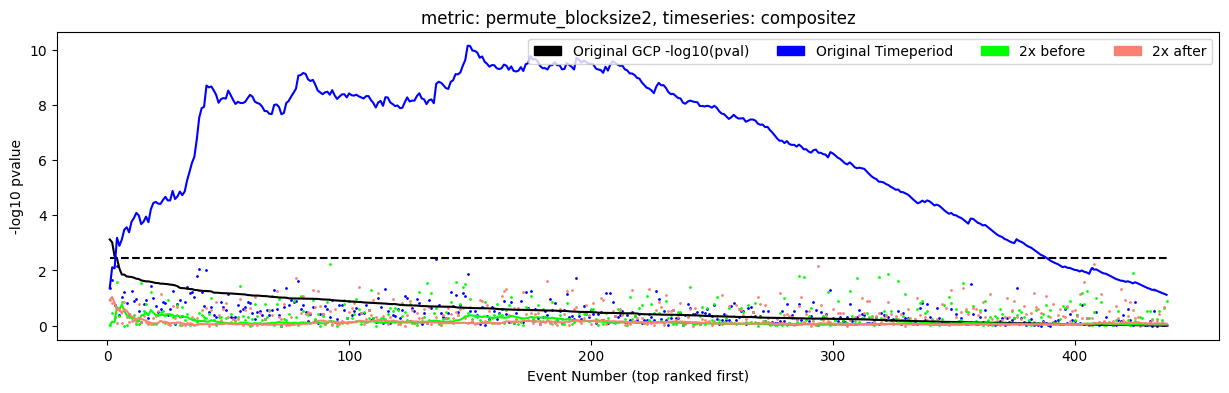

compositez
NEGATIVE permute_blocksize2
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 1.0
meta-analysis p-value: 2x before pval: 0.2019596080783843
meta-analysis p-value: 2x after pval: 0.8034393121375725


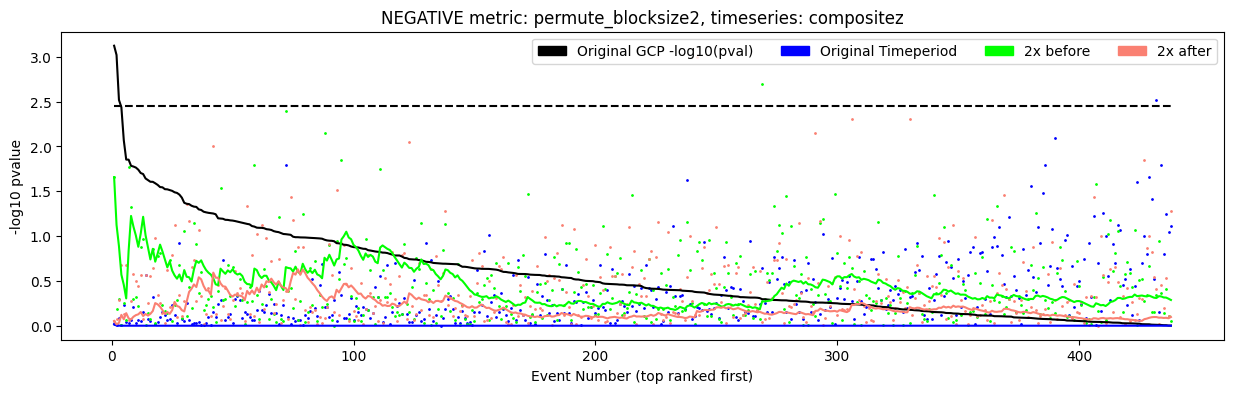

In [17]:
spannames = ['test', 'control1', 'control2']#, 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '2x before', '2x after']#, '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon']#, 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

blocksizes = [2]#,3,6,10,15,20]
for signalname, pvals in [('compositez', compositez_psanalysis)]:
  #sort the p values
  print(signalname)
  for metricname in (['permute_blocksize'+str(x) for x in blocksizes]):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['permute_blocksize'+str(x) for x in blocksizes]):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )
